<a href="https://colab.research.google.com/github/dqminhv/fraudulent-job-posting-detection-with-NLP/blob/main/notebook/data-cleaning-wrangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import required packages**

In [24]:
import warnings
# Ignore all warnings (not recommended in general)
warnings.filterwarnings("ignore")

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
from IPython.display import Image
import missingno as msno
from scipy.stats import chi2_contingency
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **Load data**

In [26]:
#Load csv file to a pandas DataFrame
job_postings_df = pd.read_csv('https://raw.githubusercontent.com/dqminhv/fraudulent-job-posting-detection-with-NLP/main/Data/fake_job_postings.csv')

In [27]:
#Let look at the first few row of th data frame
job_postings_df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [28]:
job_postings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [29]:
#Delete the job_id column since it has no use
job_postings_df.drop('job_id', axis=1, inplace=True)

# Data cleaning & wrangling

## **Dealing with missing values**

In [30]:
#Let look at the data type of each column and see if how many missing values there are
job_postings_df.isnull().sum()

title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

<Axes: >

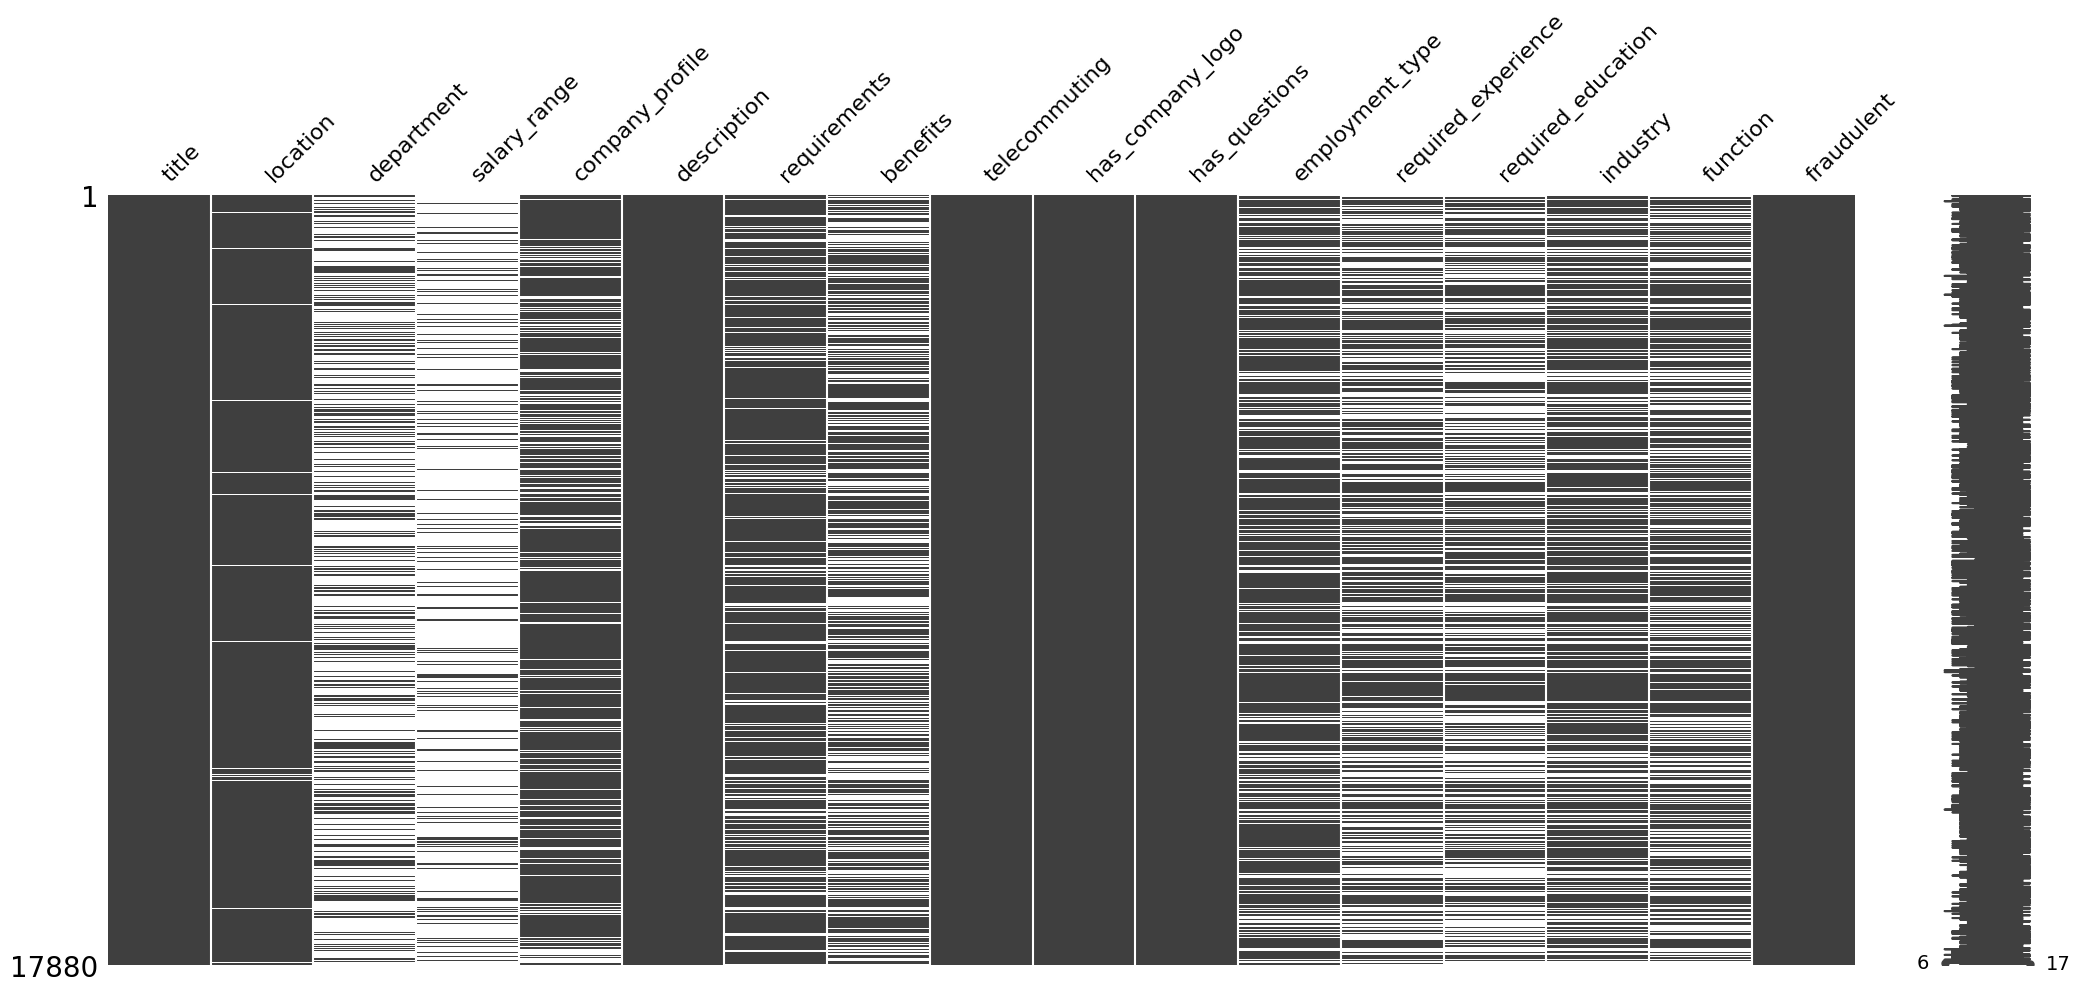

In [31]:
#missing values matrix
msno.matrix(job_postings_df)

**There appear to be numerous variables exhibiting high rates of missing values. Intuitively, we should refrain from indiscriminately discarding these variables, as the absence of data could potentially serve as an indicator of fraudulent job postings. Utilizing hypothesis testing, we can explore any potential relationship between missing values and fraudulent postings.**

In [32]:
# Create contingency table between each feature with missing values and the target variable
contingency_tables = []
for col in job_postings_df.columns:
    if job_postings_df[col].isnull().sum() > 0:
        contingency_table = pd.crosstab(job_postings_df[col].isnull(), job_postings_df['fraudulent'])
        contingency_tables.append((col, contingency_table))

# Perform chi-square contingency test for each contingency table
for col, table in contingency_tables:
    chi2, p_value, _, _ = chi2_contingency(table)
    print(f"Feature: {col}, p-value: {p_value}")

    # If p-value is less than significance level (e.g., 0.05), reject null hypothesis
    if p_value <= 0.05:
        print(f"Reject null hypothesis for feature {col}: There is a significant difference in target variable distribution between records with and without missing values.")
    else:
        print(f"Fail to reject null hypothesis for feature {col}: There is no significant difference in target variable distribution between records with and without missing values.")
    print('********************')
    print('\n')

Feature: location, p-value: 0.6595959258043212
Fail to reject null hypothesis for feature location: There is no significant difference in target variable distribution between records with and without missing values.
********************


Feature: department, p-value: 0.04312604651213151
Reject null hypothesis for feature department: There is a significant difference in target variable distribution between records with and without missing values.
********************


Feature: salary_range, p-value: 2.1067266920924934e-15
Reject null hypothesis for feature salary_range: There is a significant difference in target variable distribution between records with and without missing values.
********************


Feature: company_profile, p-value: 0.0
Reject null hypothesis for feature company_profile: There is a significant difference in target variable distribution between records with and without missing values.
********************


Feature: description, p-value: 0.03542368678855204
Reje

**The hypothesis testing shows that 'location' and 'function' feature with missing values has no association with fraudulent job posting.**

**We will drop records with missing values of the features 'location' and 'function', while imputing 'Not Specified' to the missing values of other features.**



In [33]:
job_postings_df.dropna(subset=['location', 'function'], inplace=True)
job_postings_df.fillna('Not Specified', inplace=True)

In [34]:
#Let check if there is any missing values
job_postings_df.isnull().sum()

title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

## **Job postings in the United States**

**This project focuses specifically on job postings in the US. We will first determine whether the job postings in the dataset are in the US.**

In [35]:
#Create a split function to get the country code of the location variable
def get_country(location):
    l = location.split(',')
    return l[0]

In [36]:
#Create a new column 'country_code' by spliting the location variable
job_postings_df['country_code'] = job_postings_df['location'].apply(get_country)

In [37]:
# Count occurrences of each category
country_count = job_postings_df['country_code'].value_counts()

# Get the top 5 most frequent categories
top_country = country_count.head(5).index.tolist()

# Replace all categories not in the top 5 with 'other'
job_postings_df['country_code'] = job_postings_df['country_code'].apply(lambda x: x if x in top_country else 'other')

In [38]:
#Let us what percentage of job postings are in the US
job_postings_df['country_code'].value_counts(normalize=True)*100

US       59.536196
other    16.197866
GB       14.169826
GR        5.140640
CA        2.662905
NZ        2.292567
Name: country_code, dtype: float64

**As the US job postings constitute almost 60% of the dataset, we can streamline the dataset by retaining only those from the US.**

In [39]:
#Create a data set that contain only job postings in the United States
job_postings_us_df = job_postings_df[job_postings_df['country_code']=='US']

In [40]:
#We can drop the country_code column since it has no use from now
job_postings_us_df = job_postings_us_df.drop('country_code', axis=1)
job_postings_us_df.reset_index(drop=True, inplace=True)

In [41]:
job_postings_us_df.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,Not Specified,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,Not Specified,0,1,0,Other,Internship,Not Specified,Not Specified,Marketing,0
1,Account Executive - Washington DC,"US, DC, Washington",Sales,Not Specified,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
2,Bill Review Manager,"US, FL, Fort Worth",Not Specified,Not Specified,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
3,Customer Service Associate - Part Time,"US, AZ, Phoenix",Not Specified,Not Specified,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,Not Specified,0,1,0,Part-time,Entry level,High School or equivalent,Financial Services,Customer Service,0
4,ASP.net Developer Job opportunity at United St...,"US, NJ, Jersey City",Not Specified,100000-120000,Not Specified,Position : #URL_86fd830a95a64e2b30ceed829e63fd...,Position : #URL_86fd830a95a64e2b30ceed829e63fd...,Benefits - FullBonus Eligible - YesInterview T...,0,0,0,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology,0


## **Data cleaning & wrangling**

In [42]:
#Let lower case all the text features
for col in job_postings_us_df.columns:
  if job_postings_us_df[col].dtype == 'object':
    job_postings_us_df[col] = job_postings_us_df[col].str.lower()

In [43]:
#Let explore unique values for each variable.
#We should drop 'company_profile',	'description',	'requirements',	'benefits' features because these features will most likely have a distinct value for each record
for col in job_postings_us_df.drop(['company_profile',	'description',	'requirements',	'benefits'], axis=1).columns:
  print(job_postings_us_df.value_counts(col).sort_index())
  print('\n')
  print('***************************')

title
   electrician                                                         1
   piping material engineer                                            1
  discipline manager civil, structural, marine, architectural          1
  fea senior engineer                                                  1
  manager of project management organization - engineering             1
                                                                      ..
wordpress developer                                                    1
wordpress developers                                                   1
wordpress/php engineer                                                 1
writer and content producer for early-stage startup | studyhall.com    1
writing job                                                            1
Length: 4270, dtype: int64


***************************
location
us                        48
us, ,                    225
us, ,  mclean va.          1
us, , albany               1
us, , all

**From the value count summary, we see that there are some values of some variables that can be classified as 'not specified', like 'other', 'not applicable', 'unspecified'. We should also trim the leading and trailing white spaces for variables of type string.**

In [44]:
for col in job_postings_us_df.drop(['company_profile',	'description',	'requirements',	'benefits'], axis=1).columns:
  job_postings_us_df[col] = job_postings_us_df[col].replace(['not applicable','unspecified', 'not applicable', 'other'],'not specified')
  if job_postings_us_df[col].dtype == 'object':
    job_postings_us_df[col] = job_postings_us_df[col].str.strip()
  print(job_postings_us_df.value_counts(col).sort_index())
  print('\n')
  print('***************************')

title
$950/week truck drivers needed                                         1
$950/week. truck drivers needed                                        1
(senior) structural engineer                                           1
(work from home) $20/hr                                                1
. net developers                                                       1
                                                                      ..
wordpress developer                                                    1
wordpress developers                                                   1
wordpress/php engineer                                                 1
writer and content producer for early-stage startup | studyhall.com    1
writing job                                                            1
Length: 4141, dtype: int64


***************************
location
us                        48
us, ,                    225
us, ,  mclean va.          1
us, , albany               1
us, , all

# **Export job postings in the US data to a csv file**

In [46]:
#Export the job postings in the US data to a csv file
#Download the file and upload it to the GitHub data folder
job_postings_us_df.to_csv('job-posting-us.csv', index=False)